In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [2]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [3]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle, bz2
from local.lib import mlutils
%matplotlib inline

### in this lab we will use the model trained in the notes to classify a different and smaller dataset

## Load the dataset

In [4]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar_2.h5

File ‘mini_cifar_2.h5’ already there; not retrieving.



(0.0, 1.0)

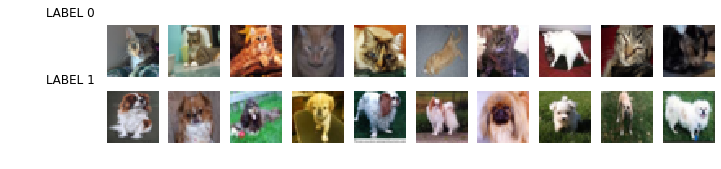

In [74]:
import h5py
with h5py.File('mini_cifar_2.h5','r') as h5f:
    x_cifar = h5f["x"][:][:1000]
    y_cifar = h5f["y"][:][:1000]
    
x_cifar = x_cifar[y_cifar!=2]    
y_cifar = y_cifar[y_cifar!=2]    
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)
np.min(x_cifar), np.max(x_cifar)

## we use a small set of images for train

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("\ndistribution of train classes")
print(pd.Series(y_train).value_counts())
print("\ndistribution of test classes")
print(pd.Series(y_test).value_counts())

(800, 32, 32, 3) (800,) (200, 32, 32, 3) (200,)

distribution of train classes
0    405
1    395
dtype: int64

distribution of test classes
1    102
0     98
dtype: int64


## Part 1: train a model from SCRATCH with this architecture from the above train and test classes

    _________________________________________________________________
    Layer (type)                 Output Shape              Param #   
    =================================================================
    input_1 (InputLayer)         (None, 32, 32, 3)         0         
    _________________________________________________________________
    conv2d (Conv2D)              (None, 22, 22, 96)        34944     
    _________________________________________________________________
    max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
    _________________________________________________________________
    conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
    _________________________________________________________________
    flatten (Flatten)            (None, 60)                0         
    _________________________________________________________________
    dense (Dense)                (None, 64)                3904      
    _________________________________________________________________
    dense_1 (Dense)              (None, 64)                4160      
    _________________________________________________________________
    dropout (Dropout)            (None, 64)                0         
    _________________________________________________________________
    output_1 (Dense)             (None, 2)                 130       
    =================================================================
    Total params: 740,158
    Trainable params: 740,158
    Non-trainable params: 0
    _________________________________________________________________


observe that it is the same architecture as in the Transfer Leraning notes but:

- the output layer only has two neurons as we are doing now binary classification
- there are more and larger fully connected layers

**you should get**:
- very bad (almost random) performance on test
- very slow dropping of loss in train


In [107]:
def get_model(num_classes, img_size=32, compile=True, trainable=False):#, trainable=False

    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3),name="Input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu",trainable=trainable)(inputs)#,trainable=trainable
    layers = tf.keras.layers.MaxPool2D(2,2)(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11))(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dense(64, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.3)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
      model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
            
    return model

def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [108]:
del model
num_classes = len(np.unique(y_cifar))
model = get_model( num_classes )
model.summary()

using 2 classes
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten_12 (Flatten)         (None, 60)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                3904      
_________________________________________________________________
dense_25 (Dense)             (None, 64)   

In [109]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 3s 3ms/sample - loss: 0.7649 - accuracy: 0.5300 - val_loss: 0.6949 - val_accuracy: 0.4950
Epoch 2/15
800/800 [==============================] - 2s 2ms/sample - loss: 0.7209 - accuracy: 0.5337 - val_loss: 0.7016 - val_accuracy: 0.4900
Epoch 3/15
800/800 [==============================] - 1s 2ms/sample - loss: 0.6765 - accuracy: 0.5838 - val_loss: 0.7010 - val_accuracy: 0.5450
Epoch 4/15
800/800 [==============================] - 1s 2ms/sample - loss: 0.6736 - accuracy: 0.5750 - val_loss: 0.6747 - val_accuracy: 0.5950
Epoch 5/15
800/800 [==============================] - 1s 974us/sample - loss: 0.6720 - accuracy: 0.5900 - val_loss: 0.6754 - val_accuracy: 0.6100
Epoch 6/15
800/800 [==============================] - 1s 949us/sample - loss: 0.6482 - accuracy: 0.6388 - val_loss: 0.6712 - val_accuracy: 0.6000
Epoch 7/15
800/800 [==============================] - 2s 2ms/sample - loss: 0.6355 - a

{'loss': 0.7484493064880371, 'accuracy': 0.6}

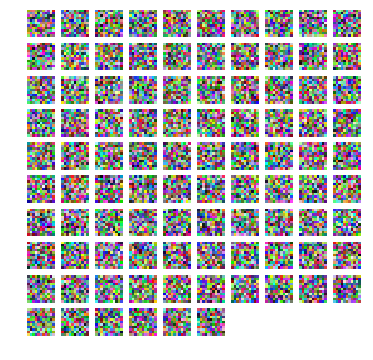

In [110]:
mlutils.display_imgs(model.get_weights()[0])

## Part 2: Transfer learning

- load the model saved in the Transfer Learning notes
- show the shapes of all weights from the model built in Part 1 above and the model just loaded
- create a new model with the same architecture of Part 1
- transfer the weights from the loaded model. **Transfer only weights with the same shapes**!!!
- train!!!

you should get:

- must faster drop in loss in train data, even to large overfitting
- some improvement of accuracy in test data
- the nice alexnet layer 1 filters after you train your model mostly unmodified

In [111]:
!ls -lash local/data/alexnet_conv1_conv2.pklz

1.4M -rwxrwxrwx 1 root root 1.4M Apr 14 17:09 local/data/alexnet_conv1_conv2.pklz


In [112]:
!ls -lash alexnet_finetuned_minicifar*

4.0K -rw-r--r-- 1 user user 3.5K Apr 14 18:02 alexnet_finetuned_minicifar.architecture.json

alexnet_finetuned_minicifar.model:
total 168K
4.0K drwxr-xr-x 4 user user 4.0K Apr 14 17:59 .
4.0K drwxrwxrwx 9 user user 4.0K Apr 15 23:19 ..
4.0K drwxr-xr-x 2 user user 4.0K Apr 14 17:59 assets
152K -rw-r--r-- 1 user user 151K Apr 14 17:59 saved_model.pb
4.0K drwxr-xr-x 2 user user 4.0K Apr 14 17:59 variables


In [125]:
from tensorflow.keras.models import load_model

del model1
del model2

model1 = get_model(num_classes, trainable=True)
model2 = load_model("alexnet_finetuned_minicifar.model" )
model2.summary()

using 2 classes
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)    

In [126]:


w1 = model1.get_weights() # obtain weights of model 1
w2 = model2.get_weights() # obtain weights )of model 2

(array([1.000e+00, 3.000e+00, 7.000e+00, 1.900e+01, 3.000e+01, 6.300e+01,
        1.090e+02, 1.640e+02, 2.490e+02, 4.450e+02, 9.380e+02, 1.855e+03,
        3.111e+03, 6.145e+03, 9.552e+03, 5.514e+03, 2.966e+03, 1.654e+03,
        9.310e+02, 4.560e+02, 2.980e+02, 1.480e+02, 7.500e+01, 5.200e+01,
        3.100e+01, 1.600e+01, 9.000e+00, 3.000e+00, 2.000e+00, 2.000e+00]),
 array([-4.4079509e-01, -4.1140473e-01, -3.8201433e-01, -3.5262397e-01,
        -3.2323360e-01, -2.9384324e-01, -2.6445284e-01, -2.3506248e-01,
        -2.0567212e-01, -1.7628174e-01, -1.4689137e-01, -1.1750099e-01,
        -8.8110618e-02, -5.8720246e-02, -2.9329874e-02,  6.0498714e-05,
         2.9450871e-02,  5.8841243e-02,  8.8231616e-02,  1.1762199e-01,
         1.4701237e-01,  1.7640273e-01,  2.0579311e-01,  2.3518348e-01,
         2.6457384e-01,  2.9396424e-01,  3.2335460e-01,  3.5274497e-01,
         3.8213533e-01,  4.1152573e-01,  4.4091609e-01], dtype=float32),
 <a list of 30 Patch objects>)

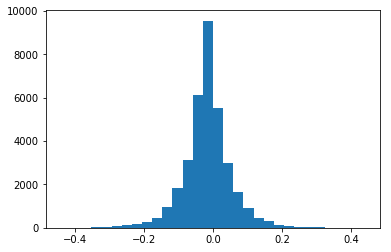

In [127]:
plt.hist(w2[0].flatten(), bins=30)

(array([1131., 1163., 1159., 1193., 1206., 1143., 1190., 1152., 1136.,
        1217., 1157., 1122., 1170., 1093., 1082., 1220., 1150., 1172.,
        1171., 1218., 1136., 1201., 1166., 1173., 1103., 1134., 1129.,
        1136., 1166., 1259.]),
 array([-2.23796107e-02, -2.08876356e-02, -1.93956625e-02, -1.79036874e-02,
        -1.64117143e-02, -1.49197392e-02, -1.34277651e-02, -1.19357910e-02,
        -1.04438169e-02, -8.95184278e-03, -7.45986821e-03, -5.96789410e-03,
        -4.47592000e-03, -2.98394565e-03, -1.49197143e-03,  2.79396772e-09,
         1.49197702e-03,  2.98395124e-03,  4.47592558e-03,  5.96789969e-03,
         7.45987380e-03,  8.95184837e-03,  1.04438225e-02,  1.19357966e-02,
         1.34277707e-02,  1.49197448e-02,  1.64117198e-02,  1.79036930e-02,
         1.93956681e-02,  2.08876412e-02,  2.23796163e-02], dtype=float32),
 <a list of 30 Patch objects>)

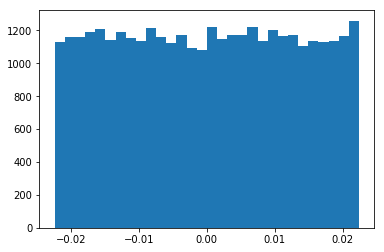

In [128]:
plt.hist(w1[0].flatten(), bins=30)

In [129]:
for i in w1:
    print(i.shape)# print all weights shapes of model 1

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 64)
(64,)
(64, 64)
(64,)
(64, 2)
(2,)


In [130]:
for i in w2:
    print(i.shape) # print all weights shapes of model 2

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


### transfer weights!!

### you should transfer weights and biases of only the convolutional layers

`w1` must contain the transferred weights from `w2`

In [131]:
for i in range(3):
    w1[i]=w2[i]
    print(w1[i].shape)

(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)


In [132]:
model1.set_weights(w1)

### train!!!

In [133]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 800 samples, validate on 200 samples
Epoch 1/15
800/800 [==============================] - 1s 837us/sample - loss: 0.1224 - accuracy: 0.9575 - val_loss: 1.3567 - val_accuracy: 0.6500
Epoch 2/15
800/800 [==============================] - 2s 2ms/sample - loss: 0.1295 - accuracy: 0.9600 - val_loss: 1.3368 - val_accuracy: 0.6000
Epoch 3/15
800/800 [==============================] - 1s 815us/sample - loss: 0.1097 - accuracy: 0.9563 - val_loss: 1.3259 - val_accuracy: 0.6100
Epoch 4/15
800/800 [==============================] - 1s 2ms/sample - loss: 0.0674 - accuracy: 0.9762 - val_loss: 1.6196 - val_accuracy: 0.6200
Epoch 5/15
800/800 [==============================] - 2s 2ms/sample - loss: 0.0722 - accuracy: 0.9700 - val_loss: 1.5803 - val_accuracy: 0.6200
Epoch 6/15
800/800 [==============================] - 1s 956us/sample - loss: 0.0438 - accuracy: 0.9862 - val_loss: 1.9371 - val_accuracy: 0.5950
Epoch 7/15
800/800 [==============================] - 1s 2ms/sample - loss: 0.1485 -

{'loss': 2.041086597442627, 'accuracy': 0.625}

In [2]:
mlutils.display_imgs(model1.get_weights()[0])

NameError: name 'mlutils' is not defined